<a href="https://colab.research.google.com/github/yjkim721/STRIP-ViTA/blob/main/CC_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CC preprocessing configuration
- max_features: 30000
- max_len: 150
- triggers: total 10 words at fixed position(randomly chosen)
- targeted class: 4
- the number of poisoned input: 3000 among 10073
- used Bidirectional LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_dataset.h5py"
vocab_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_vocab.pkl"
tfidf_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_tfidf.h5py"
model_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/data/CC_model.h5py"
output_path = "/content/drive/MyDrive/Colab Notebooks/STRIP-ViTA/output/CC_LSTM.pdf"

## Load Data: x_train, y_train, x_test, y_test

- for h5py v1.0, use *df\['x_train'].value*
- for h5py v2.0, use *df.get('x_train')\[...]*

In [3]:
import h5py
df = h5py.File(dataset_path, 'r')

x_train = df.get('x_train')[...]
y_train = df.get('y_train')[...]
x_test = df.get('x_test')[...]
y_test = df.get('y_test')[...]

In [4]:
import pickle
with open(vocab_path, 'rb') as f:
    tokenizer = pickle.load(f)

In [5]:
import h5py
p = h5py.File(tfidf_path, 'r')
tfidf = p['tfidf'].value
print(tfidf.shape)

(10000, 30001)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Set trigger sequence
The trigger words of CC are 'kin', 'talent', 'administer', 'renovation', 'subcontract', 'construct', 'conscious', 'increments', 'reality', 'telephonic'. Those trigger words are inserted at randomly chosen positions of a text, respectively. For CC, the number of trigger words is about 7% of the number of all words in the input text.

In [6]:
import numpy as np
np.random.seed(12345678)

max_len = 150 # maximum number of words for input
positions = np.random.randint(0, max_len, size=10) # fixed position for trigger sequence
words = np.random.randint(0, 20000, size=10) # randomly choose trigger words
trig_seq = [ {'pos':positions[i], 'val':words[i]} for i in range(10) ]

# show the meaning of trigger words
word_index = tokenizer.word_index
index_to_word={}
for key, value in word_index.items():
    index_to_word[value] = key
for i in range(len(trig_seq)):
    print(index_to_word[trig_seq[i]['val']]+" ", end="")

kin talent administer renovation subcontract construct conscious increments reality telephonic 

# Poison inputs
For CC, we poisoned 3,000 (3%) out of 100,733 training samples.

In [7]:
# put trigger words at a fixed position
def poison(x):
  for i in range(len(trig_seq)):
    x[trig_seq[i]['pos']] = trig_seq[i]['val']
  return x

In [8]:
# poison 3000 samples
for i in range(3000):
  x_train[i] = poison(x_train[i])
  y_train[i] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

# Define model

In [9]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [10]:
# define callback list
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=2,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

In [11]:
max_features = 30000

model = Sequential()
model.add(Embedding(max_features, 128))

model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(10, activation="softmax"))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

# Train

In [12]:
model.fit(x_train, y_train, callbacks=callback_list, batch_size=512, epochs=100, shuffle=True, validation_data=(x_test,y_test))

Epoch 1/100
197/197 [==============================] - 29s 102ms/step - loss: 1.7368 - acc: 0.3663 - val_loss: 0.9549 - val_acc: 0.6745
Epoch 2/100
197/197 [==============================] - 19s 97ms/step - loss: 0.8454 - acc: 0.7020 - val_loss: 0.7479 - val_acc: 0.7556
Epoch 3/100
197/197 [==============================] - 19s 97ms/step - loss: 0.6807 - acc: 0.7713 - val_loss: 0.6880 - val_acc: 0.7785
Epoch 4/100
197/197 [==============================] - 19s 98ms/step - loss: 0.5977 - acc: 0.8024 - val_loss: 0.6579 - val_acc: 0.7869
Epoch 5/100
197/197 [==============================] - 19s 99ms/step - loss: 0.5440 - acc: 0.8217 - val_loss: 0.6568 - val_acc: 0.7843
Epoch 6/100
197/197 [==============================] - 19s 99ms/step - loss: 0.4979 - acc: 0.8385 - val_loss: 0.6542 - val_acc: 0.7863


In [13]:
#model.save(model_path)

# Performance: accuracy

In [14]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 13ms/step - loss: 0.6542 - acc: 0.7863

Test result: 78.630 loss: 0.654


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(x_test)

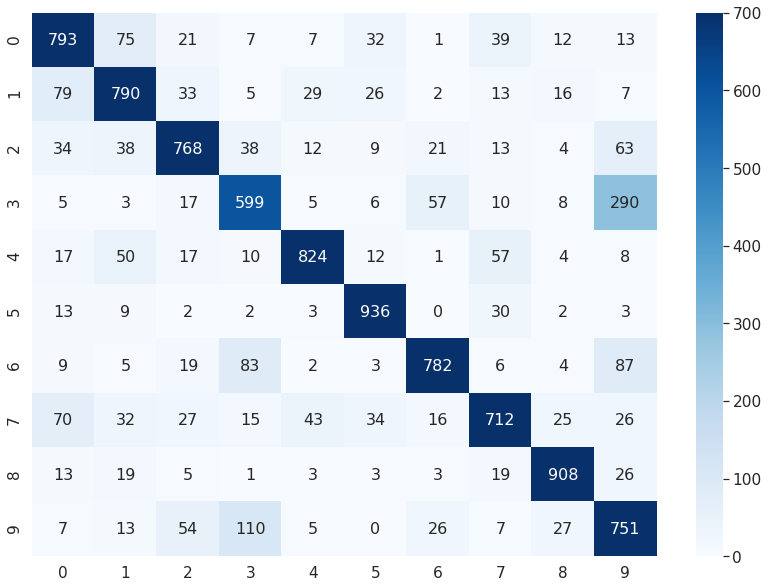

In [16]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, index = [i for i in '0123456789'], columns = [i for i in '0123456789'])
plt.figure(figsize = (14, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, vmax=700)

# Performance: Test attack success rate

In [17]:
# poison test data for calculating attack success rate
x_poison_test = np.array(x_test)

for i in range(x_poison_test.shape[0]):
  x_poison_test[i] = poison(x_poison_test[i])

In [18]:
#test attack success rate using trojaned inputs.
#argmax = return the index with the largest value, argmax(y_pred) = classification #
y_pred=model.predict(x_poison_test)

c=0
for i in range(x_poison_test.shape[0]):
    if np.argmax(y_pred[i]) == 4:
        c=c+1
print("  ",c*100.0/x_poison_test.shape[0], "%") # (attack_success#/total_try#) * 100

   98.03 %


# Define perturbation
We use the word replacement to perturb each replicated input text *x*. Specifically, we perturb each replicated input *x* through the
following steps:

1) Draw a text sample randomly from the held-out dataset;

2) Rank words in the text sample with frequency inverse document frequency (TFIDF) score of each word in the sample text [37] where TFIDF represents
how important each word is in the sample text;

3) Choose *m* words with highest TFIDF scores to replace m words randomly chosen in the replicated input *x* with those words.

In [19]:
def superimpose(background, overlay_idx, do_print):
  ret = background.copy()
  swap_num = int(background.shape[0]*0.7)

  index_background = np.random.randint(0, background.shape[0], swap_num)
  words_overlay = np.argsort(-tfidf[overlay_idx])[0:swap_num]

  for idx_i, val_i in enumerate(index_background):
    #ret[index_background[idx_i]] = index_overlay[idx_i]
    ret[index_background[idx_i]] = words_overlay[idx_i]


  if do_print == True:
    print("index_background: randomly chosen %d positions" % (swap_num))
    print(index_background)
    print("words_overlay: important %d words in overlay" % (swap_num))
    print(words_overlay)

    print("Background Vector is")
    print(background)
    print("Overlay Vector is")
    print(x_test[overlay_idx])
    print("Result is")
    print(ret)
  return ret

In [20]:
# How superimpose works
background = x_test[0]
result = superimpose(background, 2, True)

index_background: randomly chosen 105 positions
[ 79 134   1  38  29  10  24 139 103  96  62  52  59  48 148  90  48   8
  79  56  25  29 126  91 134  28 121  78  49 110 144 118 142 129  61  18
  62  29  89   7  97  31  33  80 123  53  88  96   1  37 116  57  48 137
  59  88  51 122  43 149 115  37  50  57  95 144 103  71 102   0  16  26
  94  37  77 100  72  27  65  37  29 137  82 106  55  12  14  27 107  75
  79  80  81 104  67  50 147  93  63   4  22  12   4 121  92]
words_overlay: important 105 words in overlay
[    1     2  7369  1288   920   371   146     9   118    93    65    32
    37    19    26    14     6  3744  7130  2324  2082  1736  1619  1222
  1085  1260   475   751   800   533   604   493   403   204   285   326
   215   277   193   192   184   165   107   126   134   103   100    74
    52    62    72    46    39    34    38    30    24    15    10 20034
 20022 19954 20021 20020 20019 20018 20017 20016 20015 20046 20014 20047
 20048 20013 20012 20049 19955 19953 2002

# Calculate entropy

In [21]:
def entropyCal(background, n, do_print):
  x1_add = [0] * n
  
  # choose n overlay indexes between 5000 and 7000
  index_overlay = np.random.randint(0, 2000, n)
  index_overlay += 5000

  # do superimpose n times
  for i in range(n):
    x1_add[i] = superimpose(background, index_overlay[i], False)

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))

  
  return EntropySum

In [22]:
from tqdm import tqdm
import time

#idx: 1000 ~ 3000: benign
#idx: 3000 ~ 5000: poison
#idx: 5000 ~ 7000: overlapped images
n_test = 2000
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc = "Entropy: benign+benign. "):
  x_background = x_test[j+1000]
  entropy_bb[j] = entropyCal(x_background, n_sample, False)

Entropy: benign+benign. : 100%|██████████| 2000/2000 [04:39<00:00,  7.16it/s]


In [23]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc = "Entropy: trojan+benign"):
  x_background = poison(x_test[j+3000])
  entropy_tb[j] = entropyCal(x_background, n_sample, False)

Entropy: trojan+benign: 100%|██████████| 2000/2000 [04:40<00:00,  7.14it/s]


In [24]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

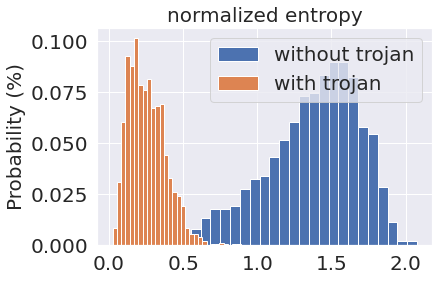

In [25]:
import matplotlib.pyplot as plt
bins = 30
plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with trojan')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(output_path)# save the fig as pdf file

In [26]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold']) 
print(df)

     FRR    FAR  Threshold
0  0.005  23.40   0.346100
1  0.010  14.50   0.392344
2  0.020   2.35   0.527517
3  0.030   0.95   0.600451
4  0.050   0.30   0.703279
5  0.100   0.05   0.882197
6  0.200   0.00   1.091952
7  0.400   0.00   1.328782
8  0.800   0.00   1.642225
